# Interactive 2D sectional-Voronoi spiderweb

By Mark Neyrinck and Johan Hidding (whose algorithm in https://github.com/jhidding/adhesion-example this is based on). See also https://arxiv.org/abs/1710.04509, Whiteley et al., https://link.springer.com/chapter/10.1007/978-0-387-92714-5_18, and articles by Robert Lang about spiderwebs and origami tessellations, e.g. "Every Spider Web Has a Simple Flat Twist Tessellation", https://books.google.com/books?id=mthYCwAAQBAJ&pg=PA190, and https://books.google.com/books?hl=en&lr=&id=r-k4GSYaV5YC&oi=fnd&pg=PA455.

Sectional-Voronoi diagrams (also known as power diagrams and additively-weighted Voronoi diagrams) are "spiderwebs", a structural-engineering term for a spatial graph that can be strung up to be entirely either in tension, or compression.  A Voronoi tessellation is a set of cells, each cell of which is the patch of space closest to its correpsonding generator. In a sectional-Voronoi tessellation, there is a constant added in quadrature to the distance function (a.k.a. "power function") used for each generator, generally different for each generator. This constant can be interpreted as a distance perpendicular to the space being tessellated, thus the tessellation can be interpreted as a "section" through a higher-dimensional space.

There are two figures below. Fig 2 shows blue dots (2D positions of generators) and black lines (sectional-Voronoi edgges). If Fig 1 remains untouched, Fig 2 is a usual Voronoi tessellation. But generators (green, in Fig 1) can be slid vertically to adjust their potential, i.e. additive weight, or "power", sliding Voronoi edges in or out in Fig 2, producing a sectional-Voronoi diagram.

To add: Delaunay visualization, representing tensions on each edge


In [1]:
import numpy as np
import bqplot # Bloomberg plotting package with straightforward interactivity
import sectional_tess #package in this repository with sectional tessellation code
import pylab as plt
from matplotlib.patches import Polygon
from matplotlib import collections
from scipy.spatial import voronoi_plot_2d
#from scipy.spatial import Voronoi, Delaunay, voronoi_plot_2d

In [2]:
# Set initial positions of generators

# 5x5 grid
# x_data = np.repeat(np.arange(5),5)
# y_data = np.tile(np.arange(5),5)

# Concentric circles:
# Outernum = #generators along an outer circle of radius 2
# Innernum is #generators along a circle of radius 1
# Default (outernum,innernum)=(3,2) produces a framework roughly resembling the Eiffel Tower
outernum = 3
innernum = 2
y_data = -np.concatenate((2.*np.cos(2.*np.pi/float(outernum)*np.arange(outernum)),
                         1.*np.cos(2.*np.pi*np.arange(innernum)/float(outernum))))+2.
x_data = np.concatenate((2.*np.sin(2.*np.pi/float(outernum)*np.arange(outernum)),
                        1.*np.sin(2.*np.pi*np.arange(innernum)/float(innernum))))+2.

In [3]:
## User interface based on https://githubqplot.com/bloomberg/bqplot/blob/master/examples/Marks/Scatter.ipynb
sc_x = bqplot.LinearScale(stabilized=True,max=5,min=-1)
sc_y = bqplot.LinearScale(stabilized=True,max=5,min=-1)

scat_height = bqplot.Scatter(x=x_data, y=y_data, scales={'x': sc_x, 'y': sc_y}, colors=['green'],
               enable_move=True, restrict_y=True)
scat_height.y_data_init = 1.*y_data
scat = bqplot.Scatter(x=x_data, y=y_data, scales={'x': sc_x, 'y': sc_y}, colors=['blue'],
               enable_move=True)

lin = bqplot.Lines(x=[], y=[], scales={'x': sc_x, 'y': sc_y}, colors=['black'])
lin_ext = bqplot.Lines(x=[], y=[], scales={'x': sc_x, 'y': sc_y}, colors=['black'])

def update_line(change=None):
    with lin.hold_sync():
        
        # if a point was added to scat
        if (len(scat.y) == len(scat_height.y) + 1):
            scat_height.y = np.append(scat_height.y, scat.y[-1])
        if (len(scat.y) == len(scat_height.y_data_init) + 1):
            scat_height.y_data_init = np.append(scat_height.y_data_init, scat.y[-1])
        if (len(scat.x) == len(scat_height.x) + 1):
            scat_height.x = np.append(scat_height.x, scat.x[-1])            
            
        # if a point was added to scat_height
        if (len(scat_height.y) == len(scat.y) + 1):
            scat.y = np.append(scat.y, scat_height.y[-1])  
        if (len(scat_height.y) == len(scat_height.y_data_init) + 1):
            scat_height.y_data_init = np.append(scat_height.y_data_init,scat_height.y[-1])
        if (len(scat_height.x) == len(scat.x) + 1):
            scat.x = np.append(scat.x, scat_height.x[-1])               
        
        # calculate sectional voronoi diagram
        vor = sectional_tess.sectional_voronoi(np.transpose(np.array([scat.x,scat.y])),
                                               scat_height.y-scat_height.y_data_init)
        
        # The rest of update_line is based on scipy.spatial.voronoi_plot_2d
        lenridgevert = len(vor.ridge_vertices)
        lin.x = -np.ones(2*lenridgevert,dtype=np.float)
        lin.y = -np.ones(2*lenridgevert,dtype=np.float)
        lin_ext.x = -np.ones(2*lenridgevert,dtype=np.float)
        lin_ext.y = -np.ones(2*lenridgevert,dtype=np.float)
        counter2 = 0
        for isimplex in range(lenridgevert):
            #print vor.ridge_vertices[isimplex]
            simplex = np.asarray(vor.ridge_vertices[isimplex])
            if np.all(simplex >= 0):
                #print simplex
                lin.x[counter2:counter2+2]= vor.vertices[simplex][:,0]
                lin.y[counter2:counter2+2]= vor.vertices[simplex][:,1]
                counter2 += 2
        lin.x = lin.x[:counter2].reshape(counter2//2,2)
        lin.y = lin.y[:counter2].reshape(counter2//2,2)
                
        center = vor.points.mean(axis=0)
        external_scale = np.sqrt(np.std(scat.x)*np.std(scat.y))
        counter2 = 0
        for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
            simplex = np.asarray(simplex)
            if np.any(simplex < 0):
                i = simplex[simplex >= 0][0]  # finite end Voronoi vertex

                t = vor.points[pointidx[1]] - vor.points[pointidx[0]]  # tangent
                normt = np.linalg.norm(t)
                if normt > 0.:
                    t /= normt
                n = np.array([-t[1], t[0]])  # normal

                midpoint = vor.points[pointidx].mean(axis=0)
                direction = np.sign(np.dot(midpoint - center, n)) * n
                far_point = vor.vertices[i] + direction*external_scale

                lin_ext.x[counter2:counter2+2]= [vor.vertices[i,0],far_point[0]]
                lin_ext.y[counter2:counter2+2]= [vor.vertices[i,1],far_point[1]]

                counter2 += 2

        lin_ext.x = lin_ext.x[:counter2].reshape(counter2//2,2)
        lin_ext.y = lin_ext.y[:counter2].reshape(counter2//2,2)

        
update_line()
# update line on change of x or y of scatter

scat_height.observe(update_line,names=['y'])

scat.observe(update_line, names=['x'])
scat.observe(update_line, names=['y'])

ax_x = bqplot.Axis(scale=sc_x)
ax_y = bqplot.Axis(scale=sc_y, orientation='vertical')

# change the bleow "with" statements to e.g. disable adding points
with scat_height.hold_sync():
    scat_height.update_on_move = True
    scat_height.update_on_add = True
    scat_height.interactions = {'click': 'add'}
#allow adding generators to 'scat_height' (Fig 1)

with scat.hold_sync():
    scat.update_on_move = True #dynamic update
    scat.update_on_add = True 
    scat.interactions = {'click': 'add'}
#allow adding generators to 'scat' (Fig 2)

/usr/local/lib/python2.7/site-packages/bqplot/traits.py:137: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(a.dtype, np.float):


Fig 1: Generators in green; slide vertically to adjust additive weights. 

Fig 2: 2D position of generators and sectional-Voronoi edges.

Generators can be added to either figure, but currently they cannot be deleted, and changes (moving or adding points) cannot be undone. Thus it can be useful to turn off point-adding.

In [4]:
bqplot.Figure(marks=[scat_height], axes=[ax_x, ax_y],min_aspect_ratio=1,max_aspect_ratio=1)

Figure(axes=[Axis(scale=LinearScale(max=5.0, min=-1.0, stabilized=True)), Axis(orientation='vertical', scale=LinearScale(max=5.0, min=-1.0, stabilized=True))], fig_margin={'top': 60, 'right': 60, 'bottom': 60, 'left': 60}, layout=Layout(min_width=u'125px'), marks=[Scatter(colors=['green'], enable_move=True, interactions={'click': 'add'}, restrict_y=True, scales={'y': LinearScale(max=5.0, min=-1.0, stabilized=True), 'x': LinearScale(max=5.0, min=-1.0, stabilized=True)}, scales_metadata={'opacity': {'dimension': 'opacity'}, 'y': {'orientation': 'vertical', 'dimension': 'y'}, 'color': {'dimension': 'color'}, 'x': {'orientation': 'horizontal', 'dimension': 'x'}, 'skew': {'dimension': 'skew'}, 'rotation': {'dimension': 'rotation'}, 'size': {'dimension': 'size'}}, tooltip_style={'opacity': 0.9}, update_on_move=True, x=array([2.        , 3.73205081, 0.26794919, 2.        , 2.        ]), y=array([0. , 3. , 3. , 1. , 2.5]))], max_aspect_ratio=1.0, scale_x=LinearScale(allow_padding=False, max=1.0, min=0.0), scale_y=LinearScale(allow_padding=False, max=1.0, min=0.0))

In [5]:
bqplot.Figure(marks=[scat, lin, lin_ext], axes=[ax_x, ax_y],min_aspect_ratio=1,max_aspect_ratio=1)

Figure(axes=[Axis(scale=LinearScale(max=5.0, min=-1.0, stabilized=True)), Axis(orientation='vertical', scale=LinearScale(max=5.0, min=-1.0, stabilized=True))], fig_margin={'top': 60, 'right': 60, 'bottom': 60, 'left': 60}, layout=Layout(min_width=u'125px'), marks=[Scatter(colors=['blue'], enable_move=True, interactions={'click': 'add'}, scales={'y': LinearScale(max=5.0, min=-1.0, stabilized=True), 'x': LinearScale(max=5.0, min=-1.0, stabilized=True)}, scales_metadata={'opacity': {'dimension': 'opacity'}, 'y': {'orientation': 'vertical', 'dimension': 'y'}, 'color': {'dimension': 'color'}, 'x': {'orientation': 'horizontal', 'dimension': 'x'}, 'skew': {'dimension': 'skew'}, 'rotation': {'dimension': 'rotation'}, 'size': {'dimension': 'size'}}, tooltip_style={'opacity': 0.9}, update_on_move=True, x=array([2.        , 3.73205081, 0.26794919, 2.        , 2.        ]), y=array([0. , 3. , 3. , 1. , 2.5])), Lines(colors=['black'], interactions={'hover': 'tooltip'}, scales={'y': LinearScale(max=5.0, min=-1.0, stabilized=True), 'x': LinearScale(max=5.0, min=-1.0, stabilized=True)}, scales_metadata={'y': {'orientation': 'vertical', 'dimension': 'y'}, 'x': {'orientation': 'horizontal', 'dimension': 'x'}, 'color': {'dimension': 'color'}}, tooltip_style={'opacity': 0.9}, x=array([[ 2.        ,  0.84529946],
       [ 2.        ,  3.15470054],
       [-0.59807621,  0.84529946],
       [-0.59807621,  4.59807621],
       [ 0.84529946,  3.15470054],
       [ 4.59807621,  3.15470054]]), y=array([[5.75, 1.75],
       [5.75, 1.75],
       [0.5 , 1.75],
       [0.5 , 0.5 ],
       [1.75, 1.75],
       [0.5 , 1.75]])), Lines(colors=['black'], interactions={'hover': 'tooltip'}, scales={'y': LinearScale(max=5.0, min=-1.0, stabilized=True), 'x': LinearScale(max=5.0, min=-1.0, stabilized=True)}, scales_metadata={'y': {'orientation': 'vertical', 'dimension': 'y'}, 'x': {'orientation': 'horizontal', 'dimension': 'x'}, 'color': {'dimension': 'color'}}, tooltip_style={'opacity': 0.9}, x=array([[ 2.        ,  2.        ],
       [-0.59807621, -1.59100149],
       [ 4.59807621,  5.59100149]]), y=array([[ 5.75      ,  6.89653135],
       [ 0.5       , -0.07326568],
       [ 0.5       , -0.07326568]]))], max_aspect_ratio=1.0, scale_x=LinearScale(allow_padding=False, max=1.0, min=0.0), scale_y=LinearScale(allow_padding=False, max=1.0, min=0.0))

/usr/local/lib/python2.7/site-packages/scipy/spatial/_plotutils.py:20: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  was_held = ax.ishold()


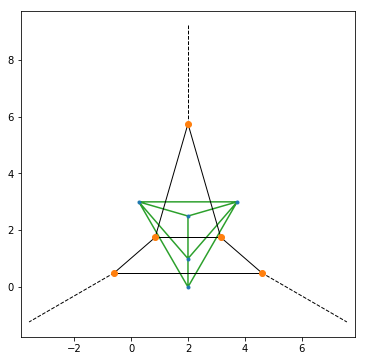

In [6]:
reload(sectional_tess)
vor = sectional_tess.sectional_voronoi(np.transpose(np.array([scat.x,scat.y])),
                                               scat_height.y-scat_height.y_data_init)
fig=plt.figure(figsize=(6,6))
ax=plt.subplot(111)
voronoi_plot_2d(vor,ax=ax)
delaun = sectional_tess.sectional_delaunay(np.transpose(np.array([scat.x,scat.y])),
                                               scat_height.y-scat_height.y_data_init)
ax.triplot(delaun.points[:,0], delaun.points[:,1], delaun.simplices)

ax.axis('equal')
plt.show()

In [7]:
print delaun.simplices

[[4 1 2]
 [3 0 2]
 [3 4 2]
 [3 0 1]
 [3 4 1]]


In [8]:
def plot_mink_fold(vor,delaun, alpha,rotangle):
    fullvorv = vor.vertices
    nvertstot = fullvorv.shape[0]
    nsimps = delaun.simplices.shape[0]
    # these should be equal
    
    unrot_edge_points = np.empty((nsimps,4,2),dtype=np.float)
    unrot_edge_points_aneg = np.empty((nsimps,4,2),dtype=np.float)
    unrot_edge_points[:,:3,:] = alpha*delaun.points[delaun.simplices.flatten(),:2].reshape(nsimps,3,2)
    unrot_edge_points_aneg[:,:3,:] = -alpha*delaun.points[delaun.simplices.flatten(),:2].reshape(nsimps,3,2)
    unrot_edge_points[:,3,:] = unrot_edge_points[:,0,:]
    unrot_edge_points_aneg[:,3,:] = unrot_edge_points_aneg[:,0,:]
        
    # rotate the points
    if rotangle > 0.:
        theta = np.radians(rotangle)
        c, s = np.cos(theta), np.sin(theta)
        R = np.array(((c,-s), (s, c)))
        Rneg = np.array(((c,s), (-s, c)))
        rot_edge_points = np.einsum('ij,klj->kli',R,unrot_edge_points)
        rot_edge_points_aneg = np.einsum('ij,klj->kli',Rneg,unrot_edge_points_aneg)
    else:
        rot_edge_points = 1.*unrot_edge_points
        rot_edge_points_aneg = 1.*unrot_edge_points
    
    for i in range(4):
        unrot_edge_points[:,i,:] += fullvorv
        unrot_edge_points_aneg[:,i,:] += fullvorv
        rot_edge_points[:,i,:] += fullvorv
        rot_edge_points_aneg[:,i,:] += fullvorv
        
    maxxie = np.max(np.abs(rot_edge_points))
    
    dists = np.empty((3,3,2),dtype=np.float)
    thresh = float(2**16+1)/float(2**16)

    filament_nodes = np.empty((6*nvertstot,2),np.int)
    filament_verts = np.empty((6*nvertstot,2),np.int)
    filcount = 0
    filpatches = []
    nodepatches = []
    
    for node in range(nvertstot):
        nodepatches.append(Polygon(rot_edge_points_aneg[node,:3,:]))
        
        #plt.text(rot_edge_points[node,0,0],rot_edge_points[node,0,1],'%d'%(node))
        for adj in range(3):
            #for each adjacent Lagrangian triangle, only draw the shortest 2 out of 9 links
            adjnode = delaun.neighbors[node,adj]
            if adjnode >= 0: #real neighbor
                for vert1 in range(3):
                    for vert2 in range(3):
                        dists[vert1,vert2,:] = unrot_edge_points[node,vert1,:]-\
                                                unrot_edge_points[adjnode,vert2,:]
                                                   
                sumdist2 = np.sum(dists**2,-1)
                mindist2 = np.min(sumdist2)
                wheremin = np.where(sumdist2/mindist2 < thresh)

                #filaments[filcount,:,:]=[node_edge_points[node,wheremin[0][0],:],
                #                         node_edge_points[node,wheremin[0][0],:]+\
                #                         alphasign*dists[wheremin[0][0],wheremin[1][0],:]]
                filament_nodes[filcount,:]=[node,adjnode]
                filament_verts[filcount,:] = [wheremin[0][0],wheremin[1][0]]
                filcount += 1
                filament_nodes[filcount,:]=[node,adjnode]
                filament_verts[filcount,:] = [wheremin[0][1],wheremin[1][1]]
                filcount += 1
                
                filpatches.append(Polygon([rot_edge_points_aneg[node,wheremin[0][0],:],
                                           rot_edge_points_aneg[adjnode,wheremin[1][0],:],
                                           rot_edge_points_aneg[adjnode,wheremin[1][1],:],
                                            rot_edge_points_aneg[node,wheremin[0][1],:]]))
                                                   


    filaments = np.empty((filcount,2,2))
    filaments = rot_edge_points[filament_nodes[:filcount,:],filament_verts[:filcount,:],:]

    filaments_aneg = rot_edge_points_aneg[filament_nodes[:filcount,:],filament_verts[:filcount,:],:]

    fig = plt.figure(figsize=[12,4])

    fig.subplots_adjust(left=0.,right=1.,top=1.,bottom=0.,hspace=0.,wspace=0.)

    ax = fig.add_subplot(131)
    ax.add_collection(collections.LineCollection(rot_edge_points[:,:,:], linewidths=0.5, color='black'))
    ax.add_collection(collections.LineCollection(filaments,linewidths=0.5, color='C0',alpha=1.))    
    ax.axis('equal')
    ax.set_xticks([]); ax.set_yticks([])
    
    ax2 = fig.add_subplot(132)
    ax2.add_collection(collections.LineCollection(rot_edge_points_aneg[:,:,:], linewidths=0.5, color='black',alpha=0.5))
    ax2.add_collection(collections.LineCollection(filaments_aneg,linewidths=0.5, color='C0',alpha=0.25))
    ax2.set_yticks([])
    ax2.set_xticks([])
    ax2.axis('equal')
    #plt.savefig('foldedform_creases.pdf',transparent=True)

    ax3 = fig.add_subplot(133)
    ax3.add_collection(collections.PatchCollection(filpatches,alpha=1./12.,color='C0'))
    ax3.add_collection(collections.PatchCollection(nodepatches,alpha=1./12.,color='black'))
    ax3.axis('equal')
    ax3.set_yticks([])
    ax3.set_xticks([])
    plt.savefig('origameiffel.pdf',transparent=True)
    
    plt.show()
    return

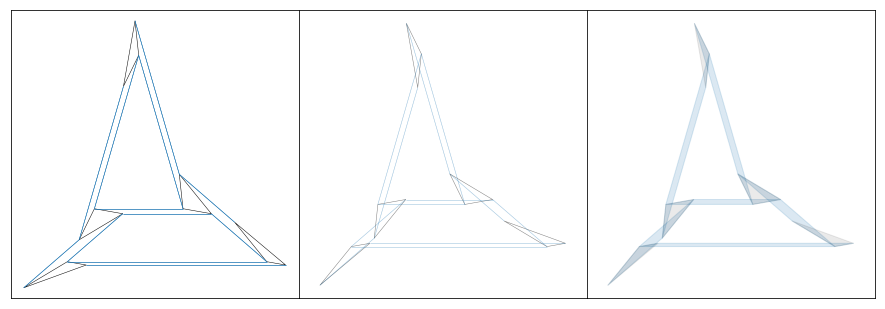

In [9]:
plot_mink_fold(vor,delaun,0.5,80.)